In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity

from scripts.oso_db import execute_query
from visualizations.sankey import make_sankey_graph

In [2]:
APP_JSON = "data/RPGF3/RPGF3_cleaned_applicant_data_final.json"
LIST_CSV = "data/RPGF3/Lists/2023-12-07_consolidated_list_data.csv"
MY_BALLOT = "data/temp/voting.tsv"

In [3]:
ids_to_names = {
    x['Project ID']: x['Project Name']
    for x in json.load(open(APP_JSON))
}
len(ids_to_names)

643

Text(0, 0.5, '# Lists')

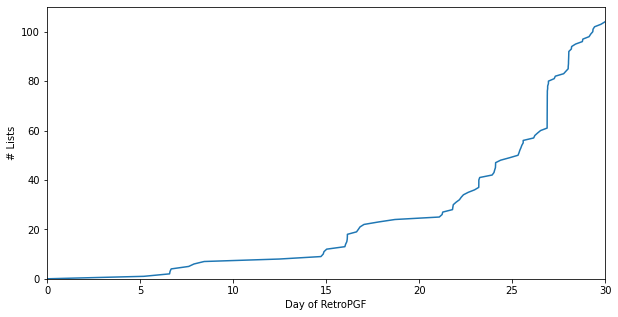

In [4]:
list_df = pd.read_csv(LIST_CSV, index_col=0)
OSO_LISTS = list(
    list_df.T[list_df.T['attester'] == "0x5a5D9aB7b1bD978F80909503EBb828879daCa9C3"]['listName'].values
)
plt.figure(figsize=(10, 5))
xs = [int(x) for x in list_df.T['timeCreated'].values]
xs = [(x - min(xs))/(24*60*60) for x in xs]
ys = np.arange(0, len(xs))
plt.plot(xs, ys)
plt.xlim(0,30)
plt.ylim(0,110)
plt.xlabel("Day of RetroPGF")
plt.ylabel("# Lists")

In [5]:
list_df = (
    pd.read_csv(LIST_CSV, index_col=0)
    .T
    .sort_values(by='timeCreated')
    .drop_duplicates(subset=['listName'], keep='last')
    .set_index('listName', drop=True)
    .drop(columns=['timeCreated', 'attester', 'count', 'sum', 'mean', 'std', 'max', 'min'])
    .rename(columns=ids_to_names)
    .T
    .applymap(float)
)
list_df.columns.name = 'List'
list_df.index.name = 'Project'
list_df.head(2)

List      OP Stack Technical Contributions  OP Onchain Gaming  \
Project                                                         
Dappnode                               NaN                NaN   
Covalent                               NaN                NaN   

List      OP Human Impact, Onboarding & Governance  Blockchain Education  \
Project                                                                    
Dappnode                                       NaN                   NaN   
Covalent                                       NaN                   NaN   

List      Ethereum's Core Protocol Stewards ⛓️🛡️  \
Project                                            
Dappnode                                     NaN   
Covalent                                     NaN   

List      Governance tooling (spengrah)  Account Abstraction Projects  \
Project                                                                 
Dappnode                            NaN                           NaN   
Covalent                            NaN                           NaN   

List      Butterbum's Collective Governance List (Updated)  \
Project                                                      
Dappnode                                               NaN   
Covalent                                               NaN   

List      Lefteris' Impactful Opensource List Recommendation v1  \
Project                                                           
Dappnode                                          1250000.0       
Covalent                                                NaN       

List      L1 Node and staking Infrastructure  ...  \
Project                                       ...   
Dappnode                            200000.0  ...   
Covalent                                 NaN  ...   

List      The WAGMI List  ۜ\(סּںסּَ`)/ۜ  Africa list (by Yoseph)  \
Project                                                          
Dappnode                          NaN                      NaN   
Covalent                          NaN                      NaN   

List      Stacked developers and authentic projects  Asia based Projects 🌏  \
Project                                                                      
Dappnode                                        NaN                    NaN   
Covalent                                        0.0                    NaN   

List      Optimism + Ethereum's scaling advocates  \
Project                                             
Dappnode                                      NaN   
Covalent                                      NaN   

List      Driving adoption in LATAM (Brichis Version)  \
Project                                                 
Dappnode                                          NaN   
Covalent                                          NaN   

List      RetroPGF 2 distribution  \
Project                             
Dappnode                  24704.0   
Covalent                      NaN   

List      Governance Tokenomics and Analytics - Individuals  \
Project                                                       
Dappnode                                                NaN   
Covalent                                                NaN   

List      ERC-4337 account abstraction related projects  Alternative v2  
Project                                                                  
Dappnode                                            NaN             NaN  
Covalent                                            NaN             NaN  

[2 rows x 100 columns]

In [6]:
list_df.unstack().dropna().median()

69307.0

75000.0

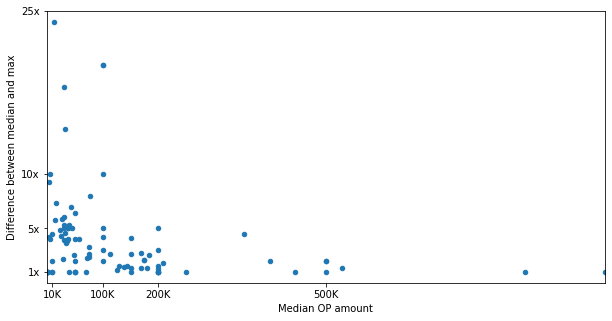

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
list_dist = []
for c in list_df.columns:
    lst = list_df[c].dropna()
    median = lst.median()
    if median == 0:
        list_dist.append({'len': len(lst), 'diff': 1, 'median': median})
    else:
        list_dist.append({'len': len(lst), 'diff': lst.max() / lst.median(), 'median': median})
ld = pd.DataFrame(list_dist)
ld['cat'] = pd.cut(ld['diff'], bins=[0,1,2,5,10,100], labels=['flat', '1-2x', '2-5x', '5-10x', '>10x'])
ld.plot(kind='scatter', x='median', y='diff', ax=ax)
ax.set_xlim(0,1000000)
ax.set_ylim(0,25)
ax.set_xlabel("Median OP amount")
ax.set_ylabel("Difference between median and max")
ax.set_yticks([1,5,10,25], labels=['1x', '5x', '10x', '25x'])
ax.set_xticks([10000,100000,200000,500000], labels=['10K', '100K', '200K','500K'])

len(ld[(ld['median'] <= 200000) & (ld['diff']<=10)])
#ld['cat'].value_counts()

ld['median'].median()

In [8]:
df = pd.read_csv(MY_BALLOT, sep='\t', thousands=',', index_col=0)
df.columns.name = 'List'
df = df[df.sum(axis=1) > 0]
df = (
    df
    .drop(columns='OP Amount')
    .unstack()
    .rename('Amount')
    .reset_index()
    .replace({
        'Breakout Protocols': 'Most Valuable Protocol (MVP)', 
        'Legacy': 'Hall of Fame Induction', 
        'Lindy List': 'Lindy Projects',
    })
    .dropna()
)
df['Domain'] = df['List'].map({
    'Most Valuable Protocol (MVP)': 'X Prizes', 
    'Hall of Fame Induction': 'X Prizes',
    'Rising Stars': 'Open Source Impact', 
    'Lindy Projects': 'Open Source Impact', 
    'Impact Vectors': 'Open Source Impact', 
    'Core Infra': 'Open Source Impact', 
    'Events & Education': 'Vibes', 
    'Collective Impact': 'Vibes', 
    'Account Abstraction': 'Breakthroughs',
    'Individuals': 'Vibes',  
    'Base': 'Breakthroughs',
    'Zora': 'Breakthroughs',    
    'PGN': 'Breakthroughs'
})
df = df[['Domain', 'List', 'Project', 'Amount']]

total_amount = df['Amount'].sum()
df['Percentage'] = (df['Amount'] / total_amount) * 100

df.head(2)

Domain                          List                       Project  \
0    X Prizes  Most Valuable Protocol (MVP)  Ethereum Attestation Service   
238  X Prizes        Hall of Fame Induction                          IPFS   

        Amount  Percentage  
0    1000000.0    3.333333  
238  1000000.0    3.333333

In [9]:
print((df.groupby('Domain')['Amount'].sum()/df['Amount'].sum()).sort_values())
px.treemap(df, path=['Domain'], values='Amount')

Domain
X Prizes              0.066667
Breakthroughs         0.163333
Vibes                 0.220000
Open Source Impact    0.550000
Name: Amount, dtype: float64


In [10]:
print((df.groupby(['Domain', 'List'])['Amount'].sum()/df['Amount'].sum()).sort_values())
px.treemap(df, path=['Domain', 'List'], values='Amount')

Domain              List                        
Breakthroughs       PGN                             0.010000
Vibes               Individuals                     0.010000
Breakthroughs       Zora                            0.020000
                    Account Abstraction             0.033333
X Prizes            Hall of Fame Induction          0.033333
                    Most Valuable Protocol (MVP)    0.033333
Breakthroughs       Base                            0.100000
Open Source Impact  Rising Stars                    0.100000
Vibes               Collective Impact               0.100000
                    Events & Education              0.110000
Open Source Impact  Core Infra                      0.150000
                    Impact Vectors                  0.150000
                    Lindy Projects                  0.150000
Name: Amount, dtype: float64


In [11]:
fig = px.line(df.groupby('Project')['Amount'].sum().sort_values(ascending=False))
fig.layout.xaxis.showticklabels=False
fig.layout.showlegend = False
fig

In [12]:
fig_data = make_sankey_graph(
    df, 
    cat_cols=['Domain', 'List'],
    value_col='Amount', 
    title=f"Carl's overall allocation of {df['Amount'].sum():,.0f} OP", 
    height=750, 
    width=750,
    decimals=False
)
fig = go.Figure(fig_data)
fig

In [13]:
fig_data = make_sankey_graph(
    df, 
    cat_cols=['List', 'Project'], 
    value_col='Amount', 
    hide_label_cols=['Project'],
    title=f"Carl's overall allocation of {df['Amount'].sum():,.0f} OP", 
    height=1000, 
    width=750
)
fig = go.Figure(fig_data)
fig

In [14]:
fig_data = make_sankey_graph(
    df, 
    cat_cols=['Domain', 'List', 'Project'], 
    value_col='Amount', 
    hide_label_cols=['Project'],
    title=f"Carl's overall allocation of {df['Amount'].sum():,.0f} OP", 
    height=1000, 
    width=750
)
fig = go.Figure(fig_data)
fig

In [15]:
def compare_lists(my_list, col='List'):
    
    my_series = df[df[col] == my_list].set_index('Project')['Amount'].rename('My Domain')
    my_projects = set(my_series.index)
    dataframe = list_df.join(my_series).fillna(0)
    col1 = dataframe['My Domain'].values.reshape(1, -1)
    results = []
    for lst in list_df.columns:
        col2 = dataframe[lst].values.reshape(1, -1)
        col2_projects = set(dataframe[lst][dataframe[lst]>0].index)
        similarity = cosine_similarity(col1, col2)[0][0]        
        membership = len(col2_projects.intersection(my_projects)) / len(my_projects)
        results.append({'List': lst, 'Similarity': similarity, 'Membership': membership})
    df_results = pd.DataFrame(results)
    df_results['Score'] = df_results['Similarity'] * df_results['Membership']    
    df_results.sort_values(by='Score', ascending=False, inplace=True)
    return df_results    

In [16]:
for lst in df["List"].unique():
    match = compare_lists(lst).head(5)
    print(lst)
    for m in match['List']:
        print("-",m)
    print()

Most Valuable Protocol (MVP)
- Governance tooling (spengrah)
- TOP Projects| Sub-category evaluated with scoring system
- Future of work
- Purely Collective Governance List
- Michael's Favorite Token House Projects

Hall of Fame Induction
- OSS Page Rank - Top 69 Results
- Bear Market Builders
- Ethereum OG Unsung Heroes (v1)
- 🔺 Ecosystem Impact Vectors 🔺
- The Lindy List

Rising Stars
- Rising Stars
- Developer Ecosystem Projects on Open Source Observer
- Popular NPM Packages
- 🔺 Ecosystem Impact Vectors 🔺
- Developer Tools - Smart Contracts

Lindy Projects
- The Lindy List
- 🔺 Ecosystem Impact Vectors 🔺
- OSS Page Rank - Top 69 Results
- Bear Market Builders
- Lefteris' Impactful Opensource List Recommendation v1

Impact Vectors
- 🔺 Ecosystem Impact Vectors 🔺
- Bear Market Builders
- Open Source Application Layer Projects Generating Revenue for the Optimism Collective
- Lean Protocols
- Developer Ecosystem Projects on Open Source Observer

Core Infra
- Ethereum Core Tech Foundations

In [17]:
def allocate_via_list(my_list, other_lists, col='List'):
    my_series = df[df[col] == my_list].set_index('Project')['Amount'].rename('My Domain')
    
    num_projects = len(my_series)
    allocations = my_series.values
    
    dataframe = list_df[other_lists].fillna(0)
    for c in other_lists:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    dataframe['Mean'] = dataframe.mean(axis=1)
    dataframe = dataframe.sort_values(by='Mean', ascending=False).head(num_projects)
    
    dfs = []
    for c in other_lists:
        values = dataframe[c]/3 * allocations
        dfs.append(pd.DataFrame({
            'My Preference': [my_list+" "] * num_projects,
            'List': [c] * num_projects,
            'Project': dataframe[c].index,
            'Amount': values
        }))
        
    result = pd.concat(dfs,axis=0, ignore_index=True)
    result['Amount'] *= sum(allocations)/result['Amount'].sum()
    return result

In [18]:
sim_series = []

for lst in df["List"].unique():
    shortlist = [x for x in compare_lists(lst)['List'].values if x not in OSO_LISTS][:5]
    d = allocate_via_list(lst, shortlist)
    sim_series.append(d)

In [19]:
sim_df = pd.concat(sim_series, axis=0)
sim_df.head()

My Preference  \
0  Most Valuable Protocol (MVP)    
1  Most Valuable Protocol (MVP)    
2  Most Valuable Protocol (MVP)    
3  Most Valuable Protocol (MVP)    
4  Most Valuable Protocol (MVP)    

                                                List  \
0                      Governance tooling (spengrah)   
1  TOP Projects| Sub-category evaluated with scor...   
2                                     Future of work   
3                  Purely Collective Governance List   
4            Michael's Favorite Token House Projects   

                        Project         Amount  
0  Ethereum Attestation Service  188425.330255  
1  Ethereum Attestation Service  242261.095446  
2  Ethereum Attestation Service  242261.095446  
3  Ethereum Attestation Service   84791.383406  
4  Ethereum Attestation Service  242261.095446

In [20]:
sim_df['List'].nunique()

38

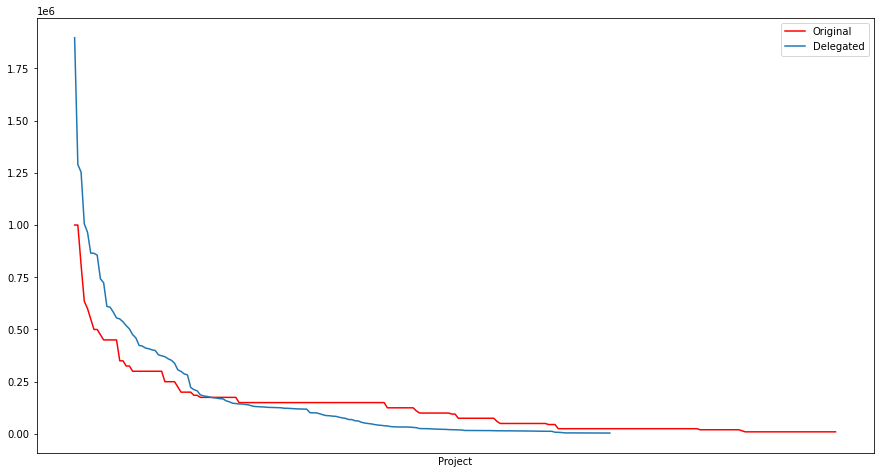

In [21]:
fig, ax = plt.subplots(figsize=(15,8))

s_org = df.groupby('Project')['Amount'].sum().sort_values(ascending=False).rename('Original')
s_sim = sim_df.groupby('Project')['Amount'].sum().sort_values(ascending=False).rename('Delegated')

s_org.plot(kind='line', color='red', ax=ax)
s_sim.plot(kind='line', ax=ax)
ax.set_xticks([])
ax.legend()

# fig.layout.xaxis.showticklabels=False
# fig.layout.showlegend = False
# fig

In [22]:
df_diff = pd.concat([s_org, s_sim], axis=1)
df_diff = df_diff.fillna(0).applymap(int)
df_diff['Diff'] = df_diff.apply(lambda x: abs(x['Original'] - x['Delegated']), axis=1)
df_diff.sort_values(by='Delegated').tail(20)

Original  Delegated     Diff
Project                                                   
Snapshot                        225000     459413   234413
Kwenta                          250000     475346   225346
libp2p                          450000     502487    52487
OpenZeppelin Contracts          175000     518280   343280
go-ethereum                     635000     536966    98034
Lyra Finance                    100000     550396   450396
Erigon                          475000     555354    80354
Lodestar                        450000     582910   132910
Lighthouse                      450000     606625   156625
Vyper                           300000     610609   310609
Tally                           125000     723615   598615
ethers.js                       175000     742681   567681
Remix Project                   300000     855567   555567
Agora                           500000     864943   364943
ZORA                            600000     865297   265297
ETHGlobal                       550000     965416   415416
🏰 BuidlGuidl                    500000    1005615   505615
Ethereum Attestation Service   1000000    1253397   253397
Synthetix                       250000    1289863  1039863
Solidity                        350000    1896830  1546830

In [23]:
len(df_diff[df_diff['Delegated'] == 0])

114

In [24]:
fig_data = make_sankey_graph(
    sim_df, 
    cat_cols=['My Preference', 'List'], 
    value_col='Amount', 
    title=f"Carl's overall allocation of {df['Amount'].sum():,.0f} OP", 
    height=1000, 
    width=750
)
fig = go.Figure(fig_data)
fig

In [25]:
fig_data = make_sankey_graph(
    sim_df, 
    cat_cols=['My Preference', 'List', 'Project'], 
    value_col='Amount', 
    hide_label_cols=['Project'],
    title=f"Carl's overall allocation of {df['Amount'].sum():,.0f} OP", 
    height=1000, 
    width=750
)
fig = go.Figure(fig_data)
fig

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 1756 (\N{ARABIC SMALL HIGH SEEN}) missing from current font.

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Matplotlib currently does not support Arabic natively.

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127759 (\N{EARTH GLOBE ASIA-AUSTRALIA}) missing from current font.

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.



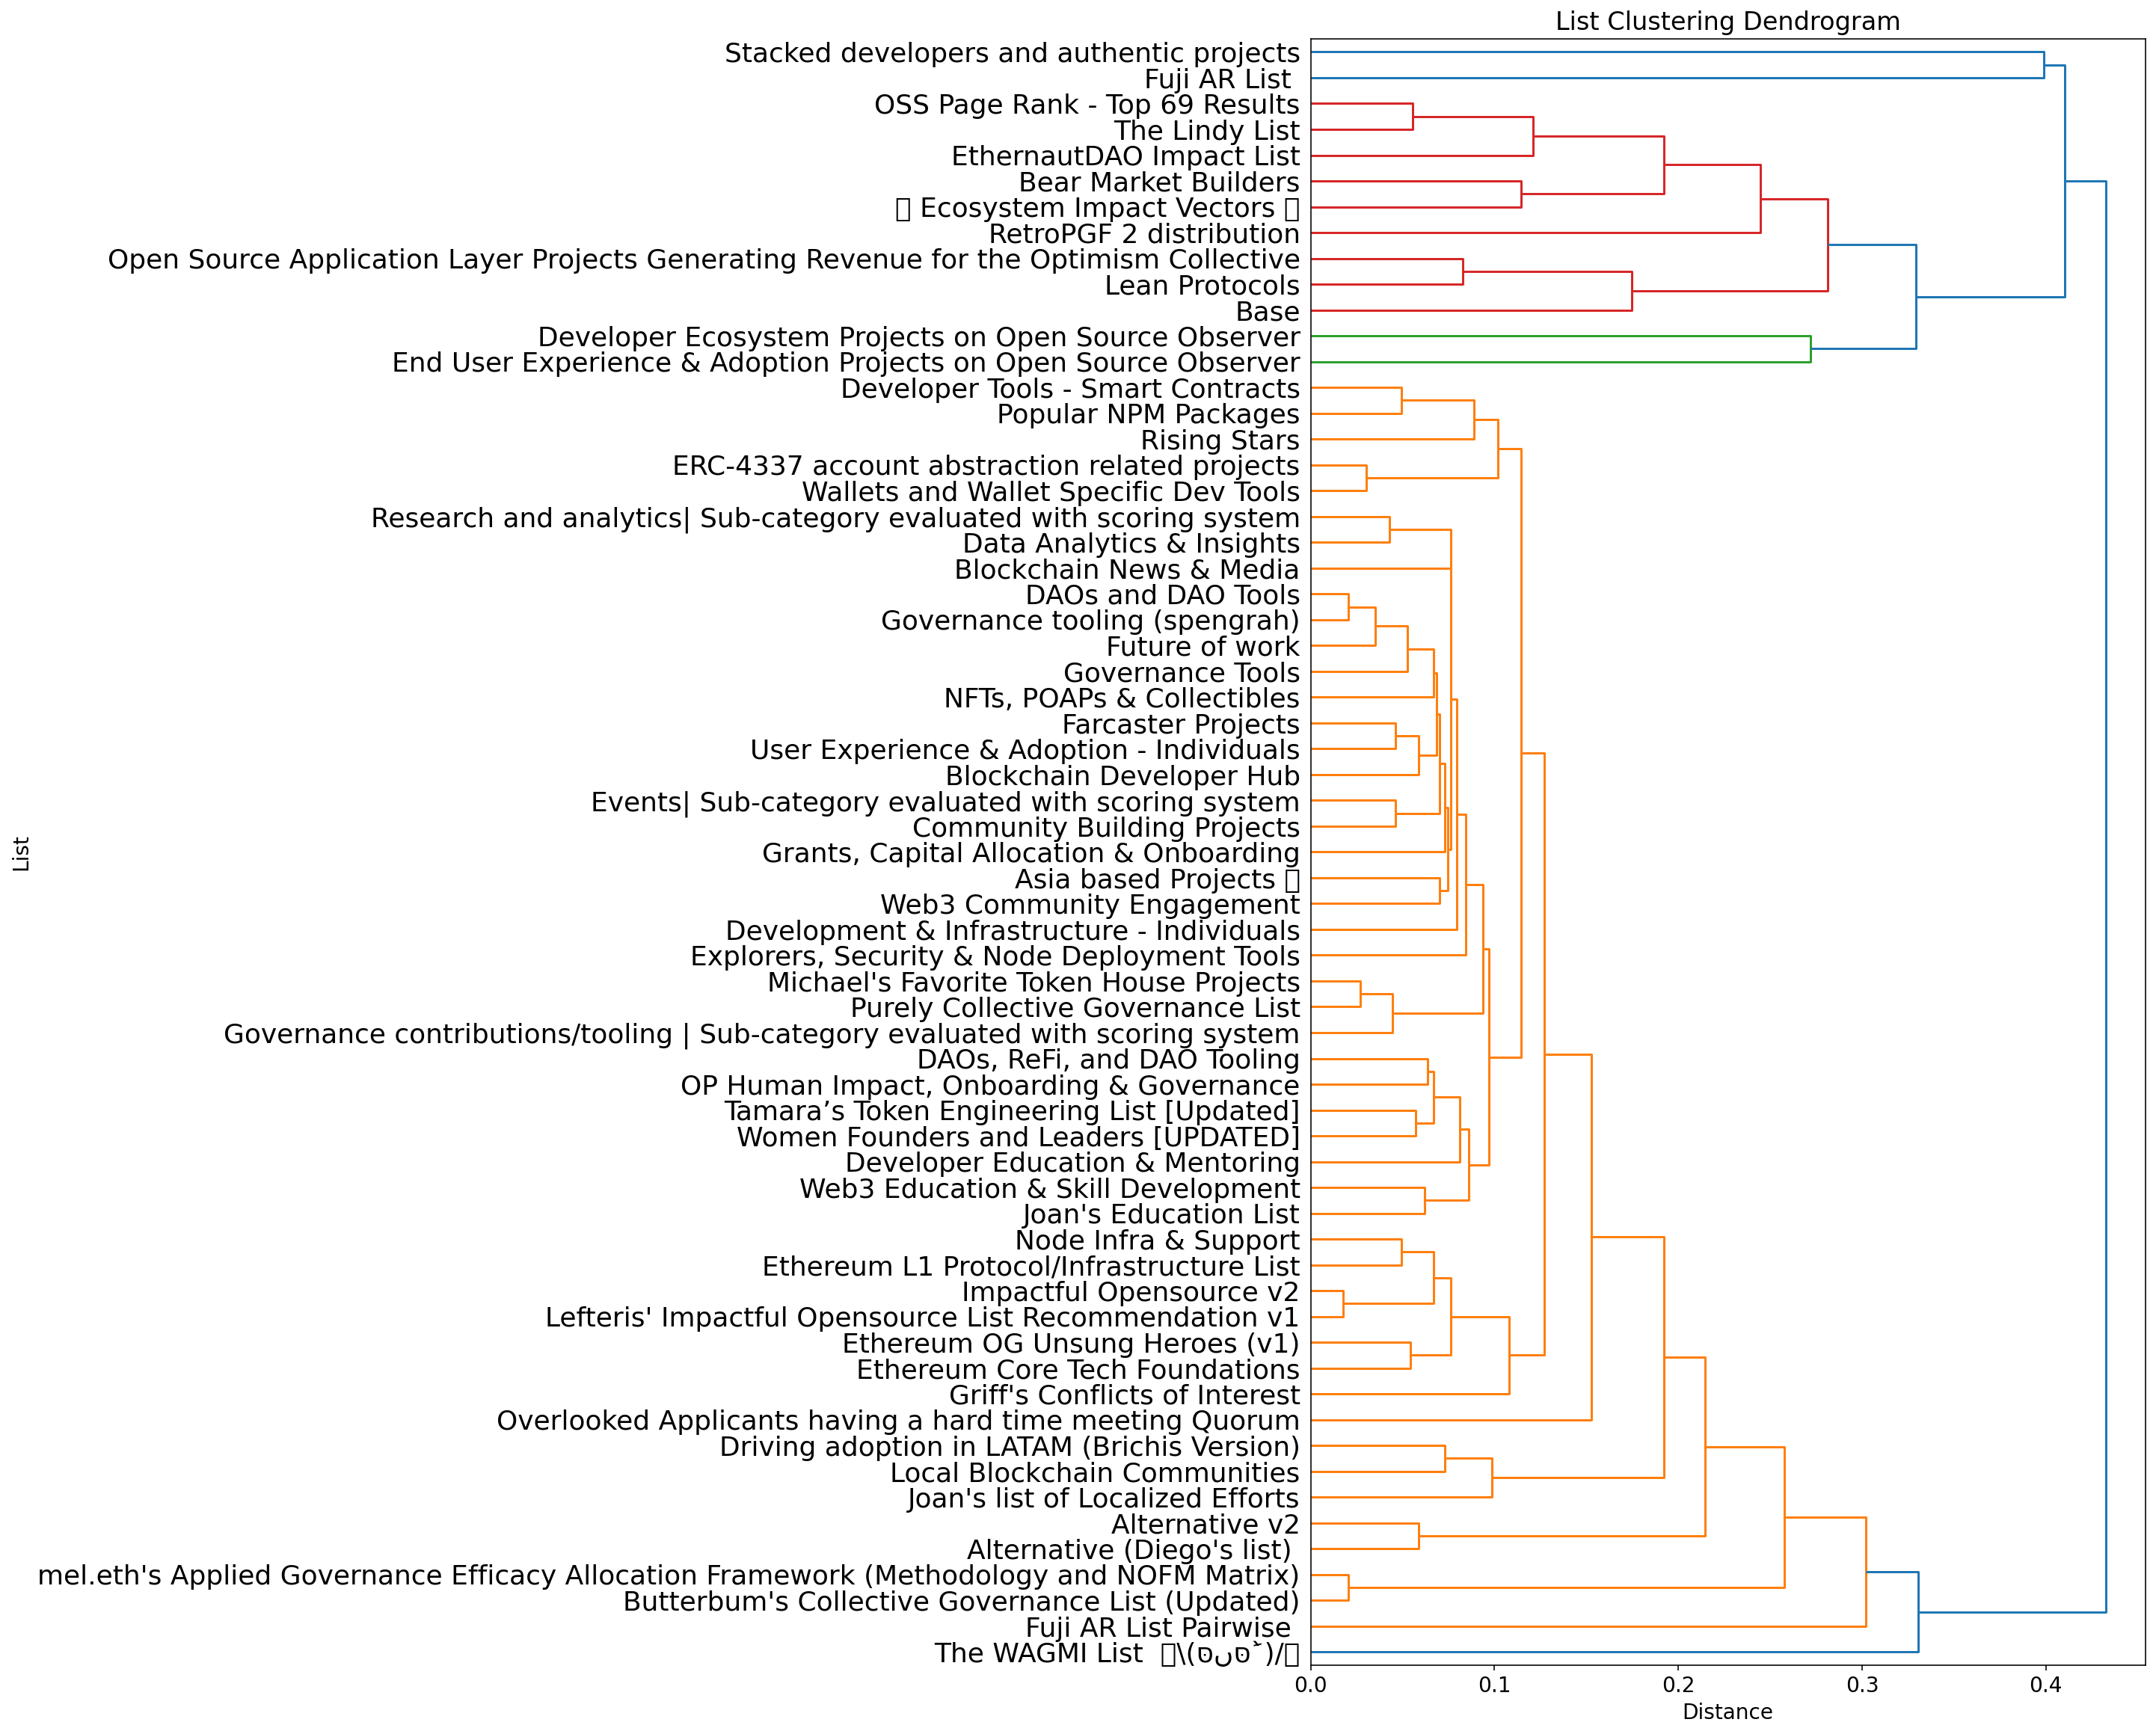

In [26]:
binary_df = ((list_df.isna() == False)*1).T
filtered = binary_df[binary_df.sum(axis=1) > 15]

linked = linkage(filtered, method='complete', metric='hamming')

plt.figure(figsize=(10, 20), dpi=144)
plt.rcParams['font.size'] = 14
dendrogram(
    linked, 
    labels=filtered.index, 
    orientation='right', 
    distance_sort='ascending', 
    show_leaf_counts=True
)
plt.title('List Clustering Dendrogram')
plt.ylabel('List')
plt.yticks(fontsize=18)
plt.xlabel('Distance')
plt.show()